In [148]:
import pickle
import pandas as pd
import os
from transformers import GPT2Tokenizer
import openai
import numpy as np
import ipdb
import re
import tqdm
import conlleval

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
import spacy

nlp = spacy.load("en_core_web_sm")

In [511]:
import glob

In [626]:
pd.set_option('max_rows',500,'max_colwidth',1000)
pd.options.display.float_format = "{:,.2f}".format

In [704]:
data_name = 'bc5cdr_disease'
seed = 42
few_shot_num = 5
number_of_test_samples = 50
selection_strategy = 'random'
sep = ', '
engine='davinci'
logit_bias = 10
sep_logit_bias = 10
new_line_logit_bias = 10
filtering=0.5

prompt_filename = '../data/{}_test_prompts_{}_{}.{}.{}.{}'.format(data_name, selection_strategy,seed,few_shot_num,number_of_test_samples,sep)
filename_root = prompt_filename.split('/')[-1]

In [537]:
preds_filename = '../outputs/'+filename_root+'.preds.{}'.format(engine)
df = pickle.load(open(preds_filename,'rb'))

FileNotFoundError: [Errno 2] No such file or directory: '../outputs/bc5cdr_disease_test_prompts_random_42.5.50., .preds.davinci.filter_0.5'

In [705]:
preds_filename = '../outputs/'+filename_root+'.preds.{}{}-{}-{}'.format(engine, logit_bias, sep_logit_bias, new_line_logit_bias)
if filtering > 0:
    preds_filename += '.filter_{}'.format(filtering)
df = pickle.load(open(preds_filename,'rb'))

In [706]:
filename_root

'bc5cdr_disease_test_prompts_random_42.5.50., '

In [707]:
def create_bio_preds(df, pred_name):
    """Function to create a BIO Tag from GPT-3 Predicted entities"""
    
    bio_preds = []
    post_processed_ents_col = []

    for i, row in df.iterrows():
        sent = row['sents'].lower()
        bio_tags = row['ner_seq']
        predicted_entities = row[pred_name]
        
        
        post_predicted_ents = post_processing(sent, predicted_entities)
        post_processed_ents_col.append(post_predicted_ents[:])

        #Sort by Length, Longest to Shortest
        pred_ent_inds_by_length = np.argsort([len(e) for e in post_predicted_ents])[::-1]
        post_predicted_ents = np.array(post_predicted_ents)[pred_ent_inds_by_length]
        
        bio_pred_seq = ' '+sent+' '
        
        for pred_ent in post_predicted_ents:
            pred_bios = ['I|||' for _ in pred_ent.split()]
            pred_bios[0] = 'B|||'
            
            pred_bios = ' '.join(pred_bios)
            
            bio_pred_seq = bio_pred_seq.replace(' '+pred_ent+' ', ' '+pred_bios+' ')
        
        bio_pred_seq = ' '.join(['O' if (w != 'B|||' and w != 'I|||') else w for w in bio_pred_seq.split()])
        bio_pred_seq = bio_pred_seq.replace('|','')
        bio_pred_seq = bio_pred_seq.strip()
        
        assert len(bio_tags.split()) == len(bio_pred_seq.split())
        bio_preds.append(bio_pred_seq)
        
    df['bio_preds'] = bio_preds
    df[pred_name+'.post'] = post_processed_ents_col

    return df

def evaluate_preds(df, pred_name):
    
    tp = 0
    fp = 0
    fn = 0

    post_processed_ents_col = []
    
    for i, row in df.iterrows():
        sent = row['sents']
        true_ents = row['entities']
        predicted_entities = row[pred_name]
    
        post_predicted_ents = post_processing(sent, predicted_entities)
        post_processed_ents_col.append(post_predicted_ents[:])
        
        #Metric is not equivalent to CONLL since it is possible
        #for GPT-3 to generate a phrase "A B C" and also another phrase "B C"
        for ent_ind in range(len(true_ents)):
            ent = true_ents[ent_ind]
            
            if ent in post_predicted_ents:
                tp += 1
                post_predicted_ents.pop(post_predicted_ents.index(ent))
            else:
                fn += 1
                
        fp += len(post_predicted_ents)
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    f1 = 2 * (precision * recall) / (precision + recall)
    
    print(f1)
    print("precision: {}  recall: {}  tp: {}  fp: {} fn: {}".format(precision, recall, tp, fp, fn))
    
    df[pred_name+'.post'] = post_processed_ents_col

    return df, f1, precision, recall

def post_processing(sentence, predicted_ents):
    
    post_predicted_ents = []
    
    for ent in predicted_ents:

        #Tokenizing generated text in same way as original dataset
        ent = ' '.join([s.text for s in nlp.tokenizer(ent)])
            
        #Removing phrases which are not standalone in sentence
        if ' '+ent+' ' in ' '+sentence.lower()+' ':
            post_predicted_ents.append(ent)
            
    return list(set(post_predicted_ents))

def conlleval_eval(true, preds):
    true = [[t+'-X' for t in s.split()] for s in true]
    preds = [[t+'-X' for t in s.split()] for s in preds]
    true = np.concatenate(true)
    preds = np.concatenate(preds)

    prec, recall, f1 = conlleval.evaluate(true,preds)
    
    return f1, prec, recall

In [708]:
df

,sents,ner_seq,bio_preds,entities,num_entities,num_tokens,prompts,empty_prompts,test_ready_prompt,"bc5cdr_disease_test_prompts_random_42.5.50.,","unfiltered_bc5cdr_disease_test_prompts_random_42.5.50.,","gpt3_output_bc5cdr_disease_test_prompts_random_42.5.50.,"
1078,Plasma was tested for amphetamine and the cocaine metabolite benzoylecgonine using enzyme - mediated immunoassay methodology .,O O O O O O O O O O O O O O O O O,O O O O B O O B O B O O O O O O O,[],0,0,Sentence: Plasma was tested for amphetamine and the cocaine metabolite benzoylecgonine using enzyme - mediated immunoassay methodology .\nDiseases:,Sentence: Plasma was tested for amphetamine and the cocaine metabolite benzoylecgonine using enzyme - mediated immunoassay methodology .\nDiseases:,"Sentence: Topical papaverine was used as a direct therapeutic action to manage vasospasm in a total of 11 patients .\nDiseases: vasospasm\n\nSentence: In summary , the chick embryo provides a reliable and simple experimental animal model of coniine - induced arthrogryposis .\nDiseases: arthrogryposis\n\nSentence: Her QT interval returned to normal upon withdrawal of ketoconazole .\nDiseases: \n\nSentence: Sodium bicarbonate alleviates penile pain induced by intracavernous injections for erectile dysfunction .\nDiseases: penile pain, erectile dysfunction\n\nSentence: We report a patient in whom hypersensitivity to carbamazepine presented with generalized erythroderma , a severe leukemoid reaction , eosinophilia , hyponatremia , and renal failure .\nDiseases: eosinophilia, renal failure, hypersensitivity, erythroderma, leukemoid reaction, hyponatremia\n\nSentence: Plasma was tested for amphetamine and the cocaine metabolite benzoylecgonine using enzyme - mediated immunoassay methodol...",[],[enzyme - mediated immunoassay methodology],"({'id': 'cmpl-4FtaZiBvFnqjuDnsn7744OFLxaLEe', 'object': 'text_completion', 'created': 1639693951, 'model': 'davinci:2020-05-03', 'choices': [{ ""finish_reason"": ""stop"", ""index"": 0, ""logprobs"": null, ""text"": "" enzyme - mediated immunoassay methodology"" }]}, {'enzyme - mediated immunoassay methodology': [0.8223457950796428, 0.1776542049203573]})"
2098,4 .,O O,O O,[],0,0,Sentence: 4 .\nDiseases:,Sentence: 4 .\nDiseases:,"Sentence: Topical papaverine was used as a direct therapeutic action to manage vasospasm in a total of 11 patients .\nDiseases: vasospasm\n\nSentence: In summary , the chick embryo provides a reliable and simple experimental animal model of coniine - induced arthrogryposis .\nDiseases: arthrogryposis\n\nSentence: Her QT interval returned to normal upon withdrawal of ketoconazole .\nDiseases: \n\nSentence: Sodium bicarbonate alleviates penile pain induced by intracavernous injections for erectile dysfunction .\nDiseases: penile pain, erectile dysfunction\n\nSentence: We report a patient in whom hypersensitivity to carbamazepine presented with generalized erythroderma , a severe leukemoid reaction , eosinophilia , hyponatremia , and renal failure .\nDiseases: eosinophilia, renal failure, hypersensitivity, erythroderma, leukemoid reaction, hyponatremia\n\nSentence: 4 .\nDiseases:",[],[],"({'id': 'cmpl-4FtaZrZ0aHtSegWGiRyOKWTmKlWu8', 'object': 'text_completion', 'created': 1639693951, 'model': 'davinci:2020-05-03', 'choices': [{ ""finish_reason"": ""stop"", ""index"": 0, ""logprobs"": null, ""text"": """" }]}, {'': [0.680991327025512, 0.31900867297448793]})"
1648,Animals were tested for four consecutive days ( 4 trial / day ) in MWM during which the position of hidden platform was unchanged .,O O O O O O O O O O O O O O O O O O O O O O O O O,O O O O O O O O O O O O O O O O O O O O O O O O O,[],0,0,Sentence: Animals were tested for four consecutive days ( 4 trial / day ) in MWM during which the position of hidden platform was unchanged .\nDiseases:,Sentence: Animals were tested for four consecutive days ( 4 trial / day ) in MWM during which the position of hidden platform was unchanged .\nDiseases:,"Sentence: Topical papaverine

In [709]:
gold_pred_col = []
positive_entity_threshold = 0.4
unfiltered_entities_probs = []

for i,row in df.iterrows():
    entities = row['unfiltered_' + filename_root]
    entity_probs = row['gpt3_output_' + filename_root][1]
    true_ents = row['entities']
    
    filtered_entities = []
    for entity in entities:
        if entity_probs[entity][1] > positive_entity_threshold:
            filtered_entities.append(entity)
        if entity in true_ents:
            unfiltered_entities_probs.append((entity,entity_probs[entity][0],entity_probs[entity][1],1))
        else:
            unfiltered_entities_probs.append((entity,entity_probs[entity][0],entity_probs[entity][1],0))
            
    gold_pred_col.append(filtered_entities)
    
df[filename_root] = gold_pred_col

In [710]:
phrase_probs = pd.DataFrame(unfiltered_entities_probs,columns=['phrase','negative_prob','positive_prob','true_ent'])

array([[<AxesSubplot:title={'center':'positive_prob'}>]], dtype=object)

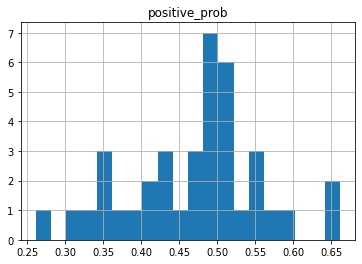

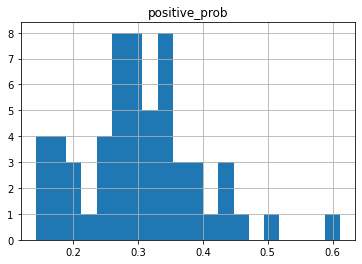

In [731]:
phrase_probs[phrase_probs.true_ent == 1][['positive_prob']].hist(bins=20)
phrase_probs[phrase_probs.true_ent == 0][['positive_prob']].hist(bins=20)

In [734]:
phrase_probs[phrase_probs.true_ent == 0].sort_values('positive_prob')

,phrase,negative_prob,positive_prob,true_ent
8,cirazoline,0.86,0.14,0
88,nanoparticles,0.86,0.14,0
63,molecular weight,0.85,0.15,0
20,nmda receptors,0.84,0.16,0
79,body compartments,0.82,0.18,0
0,enzyme - mediated immunoassay methodology,0.82,0.18,0
48,healthy,0.82,0.18,0
76,glycine cleavage system,0.82,0.18,0
5,angiographies,0.80,0.20,0
81,mesna,0.80,0.20,0


In [735]:
phrase_probs.to_csv('../outputs/bc5cdr_disease_ner_predicted_phrases.tsv')

In [712]:
df = create_bio_preds(df, filename_root)

In [713]:
f1, precision, recall = conlleval_eval(df.ner_seq,df.bio_preds)

processed 1415 tokens with 60 phrases; found: 40 phrases; correct: 32.
accuracy:  95.34%; (non-O)
accuracy:  95.34%; precision:  80.00%; recall:  53.33%; FB1:  64.00%
                X: precision:  80.00%; recall:  53.33%; FB1:  64.00%  40


In [714]:
# eval_table = []

# for filename in glob.glob('../outputs/bc5cdr_disease_test_prompts_random_42.5.50., .preds.davinci*'):
    
#     df = pickle.load(open(filename,'rb'))
#     df = create_bio_preds(df, filename_root)
#     f1, precision, recall = conlleval_eval(df.ner_seq,df.bio_preds)

#     df['unique_entities'] = [set(ents) for ents in df['entities']]
#     df['num_unique_entities'] = [len(set(ents)) for ents in df['entities']]
#     df['num_pred_ents'] = [len(set(ents)) for ents in df[filename_root]]
#     df['num_entity_diff'] = df['num_unique_entities'] - df['num_pred_ents']
#     df['num_tokens_per_true_ent'] = [np.mean([len(tokenizer.encode(ent)) for ent in set(ents)]) for ents in df.entities]
#     df['num_tokens_per_pred_ent'] = [np.mean([len(tokenizer.encode(ent)) for ent in set(ents)]) for ents in df[filename_root]]
#     df['num_tokens_per_ent_diff'] = df.num_tokens_per_true_ent - df.num_tokens_per_pred_ent
#     df['num_entities_not_in_sent'] = [np.sum([ent.replace(' ','') not in s.lower().replace(' ','') for ent in ents]) for s, ents in zip(df.sents.values, df[filename_root])]
    
#     overpred, correct, underpred = len(df[df.num_entity_diff < 0]),len(df[df.num_entity_diff == 0]), len(df[df.num_entity_diff > 0])
    
#     eval_table.append((filename, f1, precision, recall, overpred, correct, underpred))

# pd.DataFrame(eval_table)

In [715]:
# df, f1, precision, recall = evaluate_preds(df, filename_root)

In [716]:
print(df.test_ready_prompt.values[0])

Sentence: Topical papaverine was used as a direct therapeutic action to manage vasospasm in a total of 11 patients .
Diseases: vasospasm

Sentence: In summary , the chick embryo provides a reliable and simple experimental animal model of coniine - induced arthrogryposis .
Diseases: arthrogryposis

Sentence: Her QT interval returned to normal upon withdrawal of ketoconazole .
Diseases: 

Sentence: Sodium bicarbonate alleviates penile pain induced by intracavernous injections for erectile dysfunction .
Diseases: penile pain, erectile dysfunction

Sentence: We report a patient in whom hypersensitivity to carbamazepine presented with generalized erythroderma , a severe leukemoid reaction , eosinophilia , hyponatremia , and renal failure .
Diseases: eosinophilia, renal failure, hypersensitivity, erythroderma, leukemoid reaction, hyponatremia

Sentence: Plasma was tested for amphetamine and the cocaine metabolite benzoylecgonine using enzyme - mediated immunoassay methodology .
Diseases:


In [717]:
df.num_entities.sum()

55

In [718]:
df['unique_entities'] = [set(ents) for ents in df['entities']]
df['num_unique_entities'] = [len(set(ents)) for ents in df['entities']]
df['num_pred_ents'] = [len(set(ents)) for ents in df[filename_root]]
df['num_entity_diff'] = df['num_unique_entities'] - df['num_pred_ents']
df['num_tokens_per_true_ent'] = [np.mean([len(tokenizer.encode(ent)) for ent in set(ents)]) for ents in df.entities]
df['num_tokens_per_pred_ent'] = [np.mean([len(tokenizer.encode(ent)) for ent in set(ents)]) for ents in df[filename_root]]
df['num_tokens_per_ent_diff'] = df.num_tokens_per_true_ent - df.num_tokens_per_pred_ent

/home/jimenezgutierrez.1/anaconda3/envs/scispacy/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jimenezgutierrez.1/anaconda3/envs/scispacy/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [719]:
df['num_entities_not_in_sent'] = [np.sum([ent.replace(' ','') not in s.lower().replace(' ','') for ent in ents]) for s, ents in zip(df.sents.values, df[filename_root])]

In [720]:
#Percentage of entities not in sentence
len(df[df.num_entities_not_in_sent > 0])/len(df)

0.0

In [721]:
df[df.num_entities_not_in_sent > 0]

,sents,ner_seq,bio_preds,entities,num_entities,num_tokens,prompts,empty_prompts,test_ready_prompt,"bc5cdr_disease_test_prompts_random_42.5.50.,",...,"gpt3_output_bc5cdr_disease_test_prompts_random_42.5.50.,","bc5cdr_disease_test_prompts_random_42.5.50., .post",unique_entities,num_unique_entities,num_pred_ents,num_entity_diff,num_tokens_per_true_ent,num_tokens_per_pred_ent,num_tokens_per_ent_diff,num_entities_not_in_sent


In [722]:
len(df[df.num_tokens_per_ent_diff < 0]),len(df[df.num_tokens_per_ent_diff == 0]), len(df[df.num_tokens_per_ent_diff > 0])

(2, 19, 7)

<AxesSubplot:>

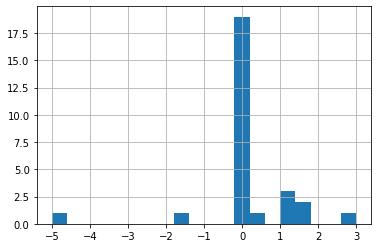

In [723]:
df.num_tokens_per_ent_diff.hist(bins=20)

In [724]:
len(df[df.num_entity_diff < 0]),len(df[df.num_entity_diff == 0]), len(df[df.num_entity_diff > 0])

(2, 34, 14)

<AxesSubplot:>

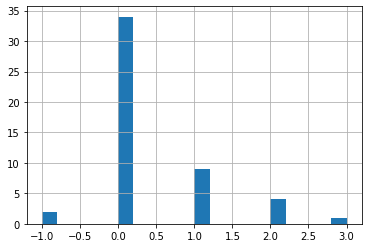

In [725]:
df.num_entity_diff.hist(bins=20)

<AxesSubplot:>

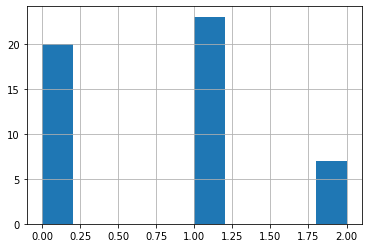

In [726]:
df.num_pred_ents.hist()

In [727]:
mea_df = df[['sents','entities',filename_root,'unfiltered_'+filename_root,'gpt3_output_'+filename_root,'ner_seq','bio_preds','test_ready_prompt']]

In [728]:
mea_df[mea_df['ner_seq'] != mea_df['bio_preds']]

,sents,entities,"bc5cdr_disease_test_prompts_random_42.5.50.,","unfiltered_bc5cdr_disease_test_prompts_random_42.5.50.,","gpt3_output_bc5cdr_disease_test_prompts_random_42.5.50.,",ner_seq,bio_preds,test_ready_prompt
2100,Both the pressor and bradycardia effects of cirazoline were abolished in chronic prazosin treated SHR ( n = 4 ) as compared to the untreated SHR ( n = 4 ) .,[bradycardia],[],"[cirazoline, prazosin, shr]","({'id': 'cmpl-4Ftadk9eCwgGsYoHdzH2QKp9zt50z', 'object': 'text_completion', 'created': 1639693955, 'model': 'davinci:2020-05-03', 'choices': [{ ""finish_reason"": ""stop"", ""index"": 0, ""logprobs"": null, ""text"": "" cirazoline, prazosin, SHR"" }]}, {'cirazoline': [0.8581130844625593, 0.1418869155374406], 'prazosin': [0.7312100745642298, 0.2687899254357702], 'shr': [0.6492963469914238, 0.35070365300857614]})",O O O O B O O O O O O O O O O O O O O O O O O O O O O O O O O O,O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O,"Sentence: Topical papaverine was used as a direct therapeutic action to manage vasospasm in a total of 11 patients .\nDiseases: vasospasm\n\nSentence: In summary , the chick embryo provides a reliable and simple experimental animal model of coniine - induced arthrogryposis .\nDiseases: arthrogryposis\n\nSentence: Her QT interval returned to normal upon withdrawal of ketoconazole .\nDiseases: \n\nSentence: Sodium bicarbonate alleviates penile pain induced by intracavernous injections for erectile dysfunction .\nDiseases: penile pain, erectile dysfunction\n\nSentence: We report a patient in whom hypersensitivity to carbamazepine presented with generalized erythroderma , a severe leukemoid reaction , eosinophilia , hyponatremia , and renal failure .\nDiseases: eosinophilia, renal failure, hypersensitivity, erythroderma, leukemoid reaction, hyponatremia\n\nSentence: Both the pressor and bradycardia effects of cirazoline were abolished in chronic prazosin treated SHR ( n = 4 ) as compar..."
457,"Following administration of these agents , the presence , and degree of fasciculation were assessed visually on a four point scale by one investigator who was blinded to the drug administered .",[fasciculation],[],[fasciculation],"({'id': 'cmpl-4FtafpdJmv6xk7Oq5rwtxF7qL13PX', 'object': 'text_completion', 'created': 1639693957, 'model': 'davinci:2020-05-03', 'choices': [{ ""finish_reason"": ""stop"", ""index"": 0, ""logprobs"": null, ""text"": "" fasciculation"" }]}, {'fasciculation': [0.6725182367147293, 0.3274817632852707]})",O O O O O O O O O O O O B O O O O O O O O O O O O O O O O O O O,O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O,"Sentence: Topical papaverine was used as a direct therapeutic action to manage vasospasm in a total of 11 patients .\nDiseases: vasospasm\n\nSentence: In summary , the chick embryo provides a reliable and simple experimental animal model of coniine - induced arthrogryposis .\nDiseases: arthrogryposis\n\nSentence: Her QT interval returned to normal upon withdrawal of ketoconazole .\nDiseases: \n\nSentence: Sodium bicarbonate alleviates penile pain induced by intracavernous injections for erectile dysfunction .\nDiseases: penile pain, erectile dysfunction\n\nSentence: We report a patient in whom hypersensitivity to carbamazepine presented with generalized erythroderma , a severe leukemoid reaction , eosinophilia , hyponatremia , and renal failure .\nDiseases: eosinophilia, renal failure, hypersensitivity, erythroderma, leukemoid reaction, hyponatremia\n\nSentence: Following administration of these agents , the presence , and degree of fasciculation were assessed visually on a four po..."
2614,One had baseline bicuspid aortic valve and mild aortic regurgitation that progressed to moderate regurgitation .,"[aortic regurgitation, bicuspid aortic valve]",[aortic regurgitation],[aortic regurgitation],"({'id': 'cmpl-4Ftannkk92Qv7WGJLNPZgDCBrF1lP', 'object': 'text_completion', 'created': 1639693965, 'model': 'davinci:2020-05-03', 'choices': [{ ""fin

In [92]:
print(df.test_ready_prompt.values[0])

Sentence: Topical papaverine was used as a direct therapeutic action to manage vasospasm in a total of 11 patients .
Drugs: papaverine

Sentence: In summary , the chick embryo provides a reliable and simple experimental animal model of coniine - induced arthrogryposis .
Drugs: coniine

Sentence: Her QT interval returned to normal upon withdrawal of ketoconazole .
Drugs: ketoconazole

Sentence: Sodium bicarbonate alleviates penile pain induced by intracavernous injections for erectile dysfunction .
Drugs: sodium bicarbonate

Sentence: We report a patient in whom hypersensitivity to carbamazepine presented with generalized erythroderma , a severe leukemoid reaction , eosinophilia , hyponatremia , and renal failure .
Drugs: carbamazepine

Sentence: Plasma was tested for amphetamine and the cocaine metabolite benzoylecgonine using enzyme - mediated immunoassay methodology .
Drugs:


In [137]:
full_dev = pickle.load(open('../data/bc5cdr_disease_test_prompts_full_dev_random_33.5., ','rb'))

In [138]:
conlleval_eval(full_dev.ner_seq,full_dev.bio_preds)

processed 116741 tokens with 4244 phrases; found: 4274 phrases; correct: 3592.
accuracy:  98.54%; (non-O)
accuracy:  98.54%; precision:  84.04%; recall:  84.64%; FB1:  84.34%
                X: precision:  84.04%; recall:  84.64%; FB1:  84.34%  4274
(84.04305100608329, 84.63713477851084, 84.33904672458323)


In [139]:
subset_with_predictions = full_dev.merge(df[['sents']],on='sents',how='inner')

In [140]:
conlleval_eval(subset_with_predictions.ner_seq,subset_with_predictions.bio_preds)

processed 5156 tokens with 191 phrases; found: 199 phrases; correct: 164.
accuracy:  98.58%; (non-O)
accuracy:  98.58%; precision:  82.41%; recall:  85.86%; FB1:  84.10%
                X: precision:  82.41%; recall:  85.86%; FB1:  84.10%  199
(82.41206030150754, 85.86387434554975, 84.1025641025641)


In [76]:
def run_gpt3(engine, prompt, logit_bias_text, sep):
    #constrain potential output to tokens in test sentence using logit bias
    logit_biases = {}
    tokens = tokenizer.encode(logit_bias_text)
    for token in tokens:
        logit_biases[token] = .1
    
    sep_token = tokenizer.encode(sep)
    logit_biases[sep_token[0]] = .1           
    
    #use API to generate completion
    sample = openai.Completion.create(engine=engine,
                                      prompt=prompt,
                                      max_tokens=10,
                                      temperature=0,
                                      logit_bias = logit_biases,
                                      presence_penalty=-0.001,
                                      stop=["\n", "<|endoftext|>"])
    return sample